Case Study 2:

This study will highlight a logistic model. 

In [1]:
import pandas as pd

# import alive
dataset = pd.read_csv("../../case_study_2/python/data/total_cells.csv")
ehux_cells = dataset.tail(15)
ehux_total_time = ehux_cells['Time (days)'].values
ehux_total_density = 1e6*ehux_cells[' Density (1e6/ml)'].values

# import dead
death_dataset = pd.read_csv("../../case_study_2/python/data/death_percentage.csv")
ehux_death = death_dataset.head(15)
ehux_dead_time = ehux_death['Time (days)']
ehux_dead_density = ehux_death[' Dead percentage '].values*ehux_total_density/100


Here is the new model. Like case study 1 part 1, we are only focusing on growth. Death will come into play later. 

Again like before I'll show both the differential equation and it's solution since PYMC needs the differential equation and humans need the solution to make understanding easier. (or at least I do)


$$
\frac{dP}{dt} = r P_0 \left(1 - \frac{P_0}{K}\right)
$$

$$
P(t) = \frac{K}{1 + \left(\frac{K - P_0}{P_0}\right) e^{-rt}}
$$


Remember when creating the ODE it needs to be an equation of lists.

In [2]:
def logistic_growth(y, t, params):
    # Use indexing instead of unpacking
    P = y[0]
    
    r = params[0]
    K = params[1]
    
    return r * (1 - P / K) * P 

Here is the Model.

In [3]:
import pymc as pm
cell_model = pm.ode.DifferentialEquation(
    func=logistic_growth,
    times=ehux_total_time,
    n_states=1,
    n_theta=2,
    t0=0
)

c:\Users\Whisk\anaconda3\envs\MCMC_Modeling\Lib\site-packages\pytensor\link\c\cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(


In [4]:
def ode_solution2data(solution):
    """
    User-defined function to extract and compute useful outputs from the ODE solution.
    
    Args:
        solution (np.ndarray): shape (time_points, num_variables)

    Returns:
        dict: keys are output variable names, values are 1D arrays over time
    """
    
    total = solution[:, 0]  # Assuming the first column is the total cell count
    return {
        "total": total
    }

One differnce here is the use of Uniform priors. Deciding on priors is a bit of a combination of art and science. 

In [5]:
import numpy as np
with pm.Model() as model:
    # Priors
    r = pm.Uniform(r"$r$ (growth rate)", lower=0.5, upper=1)
    K = pm.Uniform(r"$K$ (carrying capacity)" , lower=1e6, upper=4e7)
    P0 = pm.Uniform(r"$P_0$ (init. live)", lower=1e5, upper=3e5)
    sigma_live = pm.HalfNormal(r"$\sigma_L$", 3)

    # Solve the ODE system
    y_hat = cell_model(y0=[P0], theta=[r,K])
    #y_hat_sol = ode_solution2data(y_hat)
    # Extract live and dead cell solutions
    #total_solution = y_hat_sol['total']
    #total_solution = y_hat_sol['total']  # Match observed shape

    # pymc multiplies this itself (or additive after taking Log of Likelihood.)
    '''
    pm.Normal("Y_total", mu=pm.math.log(pm.math.clip(total_solution, 1e-8, np.inf)),sigma=sigma_live,
            observed =  np.log(ehux_total_density))
    '''   
    pm.Normal("Y_total", mu=pm.math.log(pm.math.clip(y_hat[:, 0], 1e-8, np.inf)),sigma=sigma_live,
            observed =  np.log(ehux_total_density))


In [6]:

with model:
    trace = pm.sample(draws=2000, tune=500, chains=3, return_inferencedata=True, target_accept=0.95, cores = 3) 
'''
import arviz as az
trace = az.from_netcdf("case_study_2_p1_trace.nc")
'''

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [$r$ (growth rate), $K$ (carrying capacity), $P_0$ (init. live), $\sigma_L$]


c:\Users\Whisk\anaconda3\envs\MCMC_Modeling\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 3 chains for 500 tune and 2_000 draw iterations (1_500 + 6_000 draws total) took 146 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


'\nimport arviz as az\ntrace = az.from_netcdf("case_study_2_p1_trace.nc")\n'

Sampling: [$K$ (carrying capacity), $P_0$ (init. live), $\sigma_L$, $r$ (growth rate), Y_total]


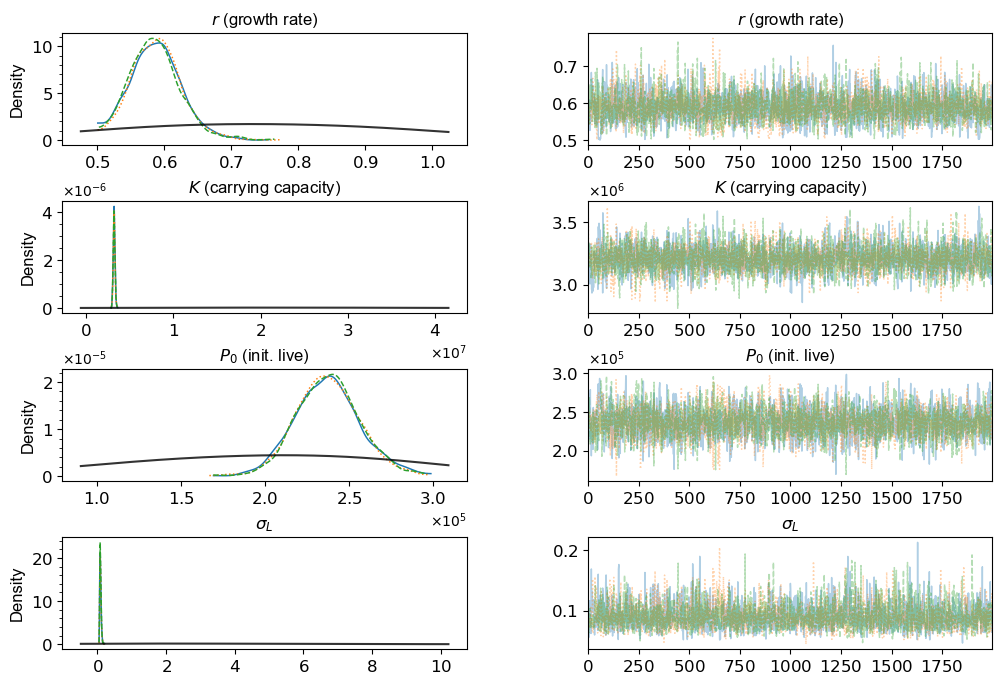

array([[<Axes: title={'center': '$r$ (growth rate)'}, ylabel='Density'>,
        <Axes: title={'center': '$r$ (growth rate)'}>],
       [<Axes: title={'center': '$K$ (carrying capacity)'}, ylabel='Density'>,
        <Axes: title={'center': '$K$ (carrying capacity)'}>],
       [<Axes: title={'center': '$P_0$ (init. live)'}, ylabel='Density'>,
        <Axes: title={'center': '$P_0$ (init. live)'}>],
       [<Axes: title={'center': '$\\sigma_L$'}, ylabel='Density'>,
        <Axes: title={'center': '$\\sigma_L$'}>]], dtype=object)

In [7]:
import sys
from pathlib import Path

# get project root by walking up 2 levels from this notebook's directory
project_root = Path.cwd().parents[1]
sys.path.insert(0, str(project_root))

from utils.plot_utils_v2 import plot_trace

plot_trace(
    trace=trace,
    model=model,
    fontname='Arial',
    fontsize=12,
    num_prior_samples=200,
    save_path='../../case_study_2/python/figures/vardi_logistic_growth_chains.png'
    )

$$
\frac{dP}{dt} = r P \left(1 - \frac{P}{K}\right) - \delta P
$$

$$
P(t) = \frac{K}{1 + \left(\frac{K - P_0}{P_0}\right) e^{-rt}}
$$

$$
\frac{dD}{dt} = \delta P
$$

$$
y(t) = y_0 e^{\mu t}
$$


Above equations are subject to change

Case Study 2: Growth and Death

Here is a a good example of why we have to return a matrix to pymc. Models can be increasingly complex and may need to track many different states and have more than just 1 equation. Here we have two equations we are going to dial in. So we essentail have a matrix of equations that we'll give. 

In [11]:
def logistic_growth_death(y, t, params):
    # Use indexing instead of unpacking
    P = y[0]
    D = y[1]
    r = params[0]
    K = params[1]
    delta = params[2]

    dydt = [0, 0]
    dydt[0] = r * (1 - P / K) * P - delta * P
    dydt[1] = delta * P
    return dydt

Here since we are tracking both growth and death as seperate observed values from the data. We have 2 states. 

In [12]:
cell_model = pm.ode.DifferentialEquation(
    func=logistic_growth_death,
    times=ehux_total_time,
    n_states=2,
    n_theta=3, # because rest goes in y0 
    t0=0
)

This portion is new. It is just a simple helper function for us. Helper functions are always nice. When in doubt, make one. It helps readibilty a great deal!

The return value from the model solution can be a little annoying to index into. So for clarity we are manually transforming the returned values into a dictionary to make life easier now that there are more moving parts in the output.

In [13]:
def ode_solution2data(solution):
    """
    User-defined function to extract and compute useful outputs from the ODE solution.
    
    Args:
        solution (np.ndarray): shape (time_points, num_variables)

    Returns:
        dict: keys are output variable names, values are 1D arrays over time
    """
    live = solution[:, 0]
    dead = solution[:, 1]
    total = live + dead
    return {
        "total": total,
        "dead": dead
    }

In [14]:
with pm.Model() as model:
    # Priors
    r = pm.Uniform(r"$r$ (growth rate)", lower=0.5, upper=1)
    K = pm.Uniform(r"$K$ (carrying capacity)" , lower=1e6, upper=4e7)
    delta = pm.Uniform(r"$\delta$ (death rate)", lower=0.0, upper=0.15)
    P0 = pm.Uniform(r"$P_0$ (init. live)", lower=1e5, upper=3e5)
    D0 = pm.Uniform(r"$D_0$ (init. dead)", lower=1e4, upper=7e4)

    sigma_live = pm.HalfNormal(r"$\sigma_L$", 3)
    sigma_dead = pm.HalfNormal(r"$\sigma_D$", 3)

    # Solve the ODE system
    y_hat = cell_model(y0=[P0,D0], theta=[r,K,delta])
    y_hat_sol = ode_solution2data(y_hat)
    # Extract live and dead cell solutions
    total_solution = y_hat_sol['total']
    dead_solution = y_hat_sol['dead']

    # pymc multiplies this itself (or additive after taking Log of Likelihood.)
    pm.Normal("Y_live", mu=pm.math.log(pm.math.clip(total_solution, 1e-8, np.inf)),sigma=sigma_live,
            observed =  np.log(ehux_total_density))

    pm.Normal("Y_dead", mu=pm.math.log(pm.math.clip(dead_solution, 1e-8, np.inf)),sigma=sigma_dead,
            observed=np.log(ehux_dead_density))

In [15]:
'''
with model:
    trace = pm.sample(draws=2000, tune=500, chains=3, return_inferencedata=True, target_accept=0.95, cores = 3) 
'''
import arviz as az
trace = az.from_netcdf("case_study_2_p2_trace.nc")

Sampling: [$D_0$ (init. dead), $K$ (carrying capacity), $P_0$ (init. live), $\delta$ (death rate), $\sigma_D$, $\sigma_L$, $r$ (growth rate), Y_dead, Y_live]


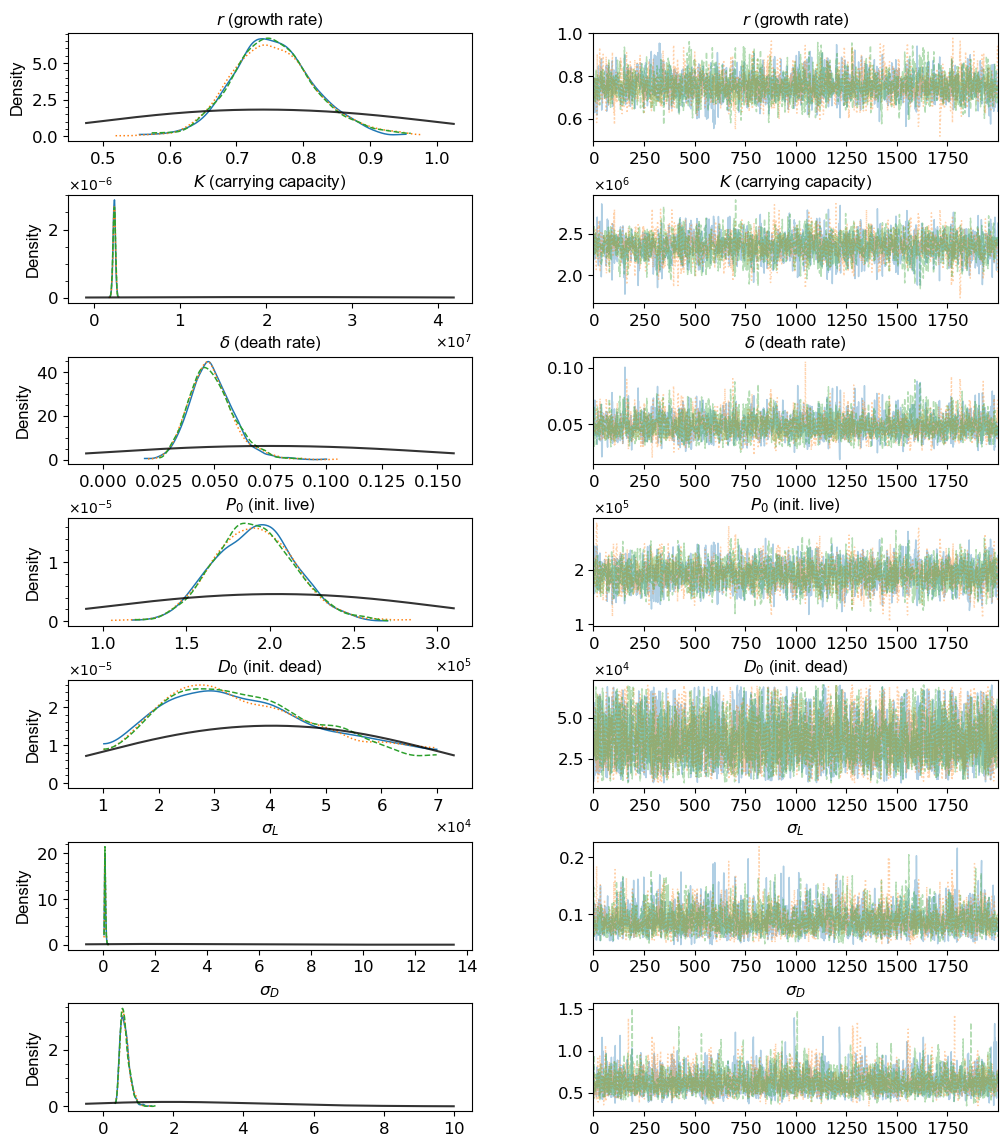

array([[<Axes: title={'center': '$r$ (growth rate)'}, ylabel='Density'>,
        <Axes: title={'center': '$r$ (growth rate)'}>],
       [<Axes: title={'center': '$K$ (carrying capacity)'}, ylabel='Density'>,
        <Axes: title={'center': '$K$ (carrying capacity)'}>],
       [<Axes: title={'center': '$\\delta$ (death rate)'}, ylabel='Density'>,
        <Axes: title={'center': '$\\delta$ (death rate)'}>],
       [<Axes: title={'center': '$P_0$ (init. live)'}, ylabel='Density'>,
        <Axes: title={'center': '$P_0$ (init. live)'}>],
       [<Axes: title={'center': '$D_0$ (init. dead)'}, ylabel='Density'>,
        <Axes: title={'center': '$D_0$ (init. dead)'}>],
       [<Axes: title={'center': '$\\sigma_L$'}, ylabel='Density'>,
        <Axes: title={'center': '$\\sigma_L$'}>],
       [<Axes: title={'center': '$\\sigma_D$'}, ylabel='Density'>,
        <Axes: title={'center': '$\\sigma_D$'}>]], dtype=object)

In [16]:
import sys
from pathlib import Path

# get project root by walking up 2 levels from this notebook's directory
project_root = Path.cwd().parents[1]
sys.path.insert(0, str(project_root))

from utils.plot_utils_v2 import plot_trace

plot_trace(
    trace=trace,
    model=model,
    fontname='Arial',
    fontsize=12,
    num_prior_samples=2000,
    save_path='../../case_study_2/python/figures/vardi_growth_death_chains.png'
    )